# Pràctica 4 (Meow)

In [2]:
import pandas as pd


# Login using e.g. `huggingface-cli login` to access this dataset
splits = {'train': 'train.tsv', 'validation': 'dev.tsv', 'test': 'test.tsv'}
df = pd.read_csv("hf://datasets/projecte-aina/sts-ca/" + splits["train"], sep="\t")

C:\Users\sambr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
import os
import numpy as np
from gensim.models import KeyedVectors
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Download FastText pre-trained word vectors for Catalan if not already downloaded
fasttext_model_path = "cc.ca.300.vec"
if not os.path.exists(fasttext_model_path):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ca.300.vec.gz
    !gunzip cc.ca.300.vec.gz

# Load the FastText model
print("Loading FastText model...")
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)
print("Model loaded")

# Function to get sentence embedding by averaging word vectors
def get_sentence_embedding(sentence, model, vector_size=300):
    words = sentence.lower().split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Prepare data for the regression model
X1 = np.array([get_sentence_embedding(sent, fasttext_model) for sent in sts_ca_dataset["sentence_1"]])
X2 = np.array([get_sentence_embedding(sent, fasttext_model) for sent in sts_ca_dataset["sentence_2"]])
Y = np.array(sts_ca_dataset["label"])

# Calculate baseline similarity scores using cosine similarity
baseline_scores = []
for i in range(len(X1)):
    sim = 1 - cosine(X1[i], X2[i])  # Cosine distance is 1 - similarity
    baseline_scores.append(sim * 5)  # Scale to 0-5 range

# Calculate baseline metrics
baseline_mse = mean_squared_error(Y, baseline_scores)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(Y, baseline_scores)

print(f"FastText Baseline Results:")
print(f"MSE: {baseline_mse:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")

# Split the data
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(
    X1, X2, Y, test_size=0.2, random_state=42
)

# Build and train the regression model for aggregated embeddings
model_agg = build_model_aggregated(embedding_dim=300)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train the model
history = model_agg.fit(
    [X1_train, X2_train], 
    Y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the model
test_loss, test_mae, test_rmse = model_agg.evaluate([X1_test, X2_test], Y_test, verbose=0)
print(f"\nModel Results on Test Data:")
print(f"MSE: {test_loss:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on test data
Y_pred = model_agg.predict([X1_test, X2_test]).flatten()

# Plot predicted vs true scores
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')  # Diagonal line representing perfect prediction
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('Regression Model: Predicted vs True Scores')
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'tensorflow.python'

In [5]:
df

,id,sentence_1,sentence_2,label
0,ACN2_111,Atorga per primer cop les mencions Encarna San...,Creen la menció M. Encarna Sanahuja a la inclu...,3.50
1,Oscar2_211,"Finalment, afegiu-hi els bolets que haureu sal...","Finalment, poseu-hi les minipastanagues tallad...",1.25
2,ACN2_574,El TC suspèn el pla d'acció exterior i de rela...,El Constitucional manté la suspensió del pla e...,3.67
3,Viqui2_341,Virgin Galactic va ser fundada el 2004 per l'e...,Virgin Atlantic és una de les aerolínies de Ri...,2.25
4,ACN2_1184,Identifiquen un nou biomarcador per realitzar ...,Nous tractaments contra el càncer de mama,2.00
...,...,...,...,...
2068,ACN2_718,Els crits de la víctima van alertar diversos c...,"La víctima, que anava amb dos amics seus, va a...",1.75
2069,Viqui2_825,Mademoiselle és una pel·lícula franco-britànic...,The Haunting és una pel·lícula britànica dirig...,2.75
2070,Viqui2_873,Però la seva idea original va resultar massa a...,Però la seva idea original va suposar quelcom ...,5.00
2071,ACN2_23,El delegat del govern al Penedès sosté que la ...,El delegat del govern al Penedès sosté que el ...,3.75


In [6]:
from datasets import load_dataset
# Text Similarity (STS) dataset (principal per la Pràctica 4)
sts_ca_dataset = load_dataset("projecte-aina/sts-ca", split="test") # O 'train', 'validation'
print(sts_ca_dataset[0])
# {'sentence1': 'Un home està fregant un terra.', 'sentence2': 'Un home està fregant un terra.', 'score': 5.0, ...}

{'id': 'Viqui2_747', 'sentence_1': "El 1921, en ser anomenat professor permanent, va fundar l'Institut d'Estadística Matemàtica de la Universitat de Göttingen.", 'sentence_2': 'El 1949 es va convertir en professor a la Universitat de Friburg de Brisgòvia, on va crear un Institut de Matemàtica Aplicada.', 'label': 2.0}


In [7]:
# Catalan General Crawling (per si volguéssiu entrenar embeddings des de zero)
# Es recomana utilitzar streaming per a datasets molt grans
cc_ca_dataset = load_dataset("projecte-aina/catalan_general_crawling", name="clean", split="train", streaming=True)
for example in cc_ca_dataset.take(1): # Agafa només el primer exemple
  print(example['text'])

C:\Users\sambr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sambr\.cache\huggingface\hub\datasets--projecte-aina--catalan_general_crawling. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ValueError: BuilderConfig 'clean' not found. Available: ['default']

In [ ]:
# Text Classification (TECLA) dataset (per la part opcional)
tecla_dataset = load_dataset("projecte-aina/tecla", name="categorization", split="train")
print(tecla_dataset[0])

# Model Baseline Cosinus

Cosine Similarity Baseline Results:
MSE: 0.6337
RMSE: 0.7960
MAE: 0.6307


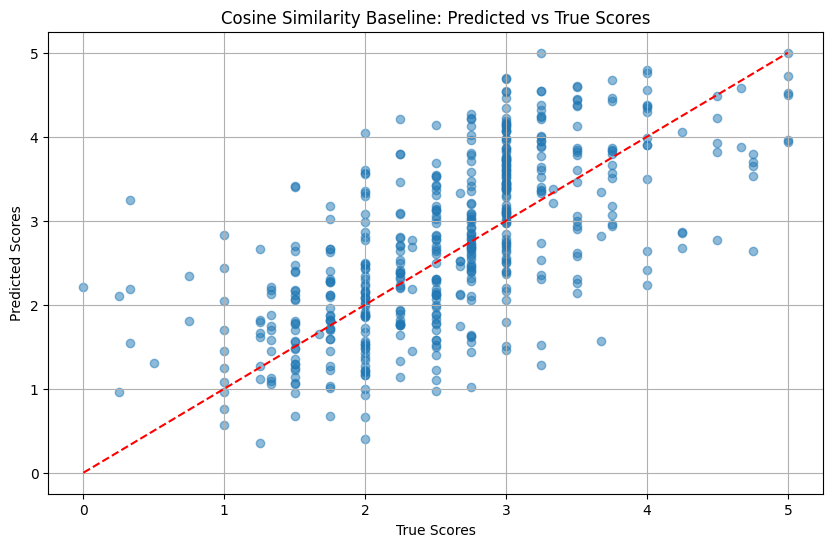

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Process the test dataset
sentences_1 = sts_ca_dataset['sentence_1']
sentences_2 = sts_ca_dataset['sentence_2']
true_scores = np.array(sts_ca_dataset['label'])

# Fit and transform sentences to TF-IDF vectors
all_sentences = sentences_1 + sentences_2
vectorizer.fit(all_sentences)
vectors_1 = vectorizer.transform(sentences_1)
vectors_2 = vectorizer.transform(sentences_2)

# Calculate cosine similarity between each pair
similarities = []
for i in range(len(sentences_1)):
    sim = cosine_similarity(vectors_1[i], vectors_2[i])[0][0]
    similarities.append(sim)

# Convert similarities to the same scale as the scores (assuming 0-5 scale)
predicted_scores = np.array(similarities) * 5

# Evaluate the model
mse = mean_squared_error(true_scores, predicted_scores)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_scores, predicted_scores)

print(f"Cosine Similarity Baseline Results:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot predicted vs true scores
plt.figure(figsize=(10, 6))
plt.scatter(true_scores, predicted_scores, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')  # Diagonal line representing perfect prediction
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('Cosine Similarity Baseline: Predicted vs True Scores')
plt.grid(True)
plt.show()

# Regressió 1: Embeddings Agregats

In [11]:
import tensorflow as tf
def build_model_aggregated(embedding_dim: int, hidden_size: int = 128, dropout_rate: float = 0.3) -> tf.keras.Model:
    input_1 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_2")
    concatenated = tf.keras.layers.Concatenate(axis=-1)([input_1, input_2])
    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(hidden_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(1)(x) # Activació lineal per a regressió
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model
model_agg = build_model_aggregated(embedding_dim=300)
model_agg.fit([X1_train, X2_train], Y_train, epochs=..., batch_size=...)

ModuleNotFoundError: No module named 'tensorflow.python'

# Model seqüencial

In [12]:
def build_model_sequential(
    input_length: int, dictionary_size: int, embedding_dim: int, 
    dense_hidden_size: int = 128, dropout_rate: float = 0.3,
    embedding_matrix=None, trainable_embeddings: bool = False,
    use_attention: bool = False, attention_units: int = 64 
) -> tf.keras.Model:
    input_1 = tf.keras.Input(shape=(input_length,), dtype=tf.int32, name="input_tokens_1")
    input_2 = tf.keras.Input(shape=(input_length,), dtype=tf.int32, name="input_tokens_2")
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0] if embedding_matrix is not None else dictionary_size, 
        output_dim=embedding_dim, input_length=input_length, 
        weights=[embedding_matrix] if embedding_matrix is not None else None,
        trainable=trainable_embeddings, mask_zero=True
    )          
    embedded_1 = embedding_layer(input_1)
    embedded_2 = embedding_layer(input_2)
    if use_attention:
        # Assegureu-vos que SimpleAttention està definida
        agg_layer_1 = SimpleAttention(units=attention_units, name="attention_1")
        agg_layer_2 = SimpleAttention(units=attention_units, name="attention_2")
    else:
        agg_layer_1 = tf.keras.layers.GlobalAveragePooling1D(name="gap_1")
        agg_layer_2 = tf.keras.layers.GlobalAveragePooling1D(name="gap_2")
    pooled_1 = agg_layer_1(embedded_1, mask=embedding_layer.compute_mask(input_1) if use_attention else None) 
    pooled_2 = agg_layer_2(embedded_2, mask=embedding_layer.compute_mask(input_2) if use_attention else None)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([pooled_1, pooled_2])
    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(dense_hidden_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)    
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001), 
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model


NameError: name 'tf' is not defined